In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


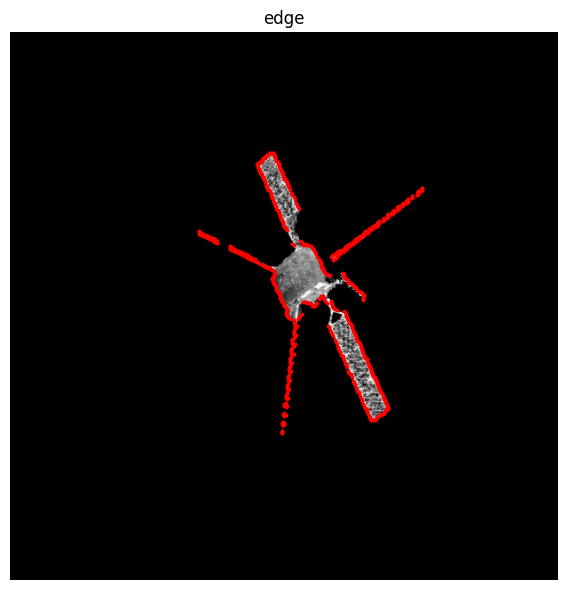

In [2]:
# define edge detection
import numpy as np
import cv2
from matplotlib import pyplot as plt

def find_edge_pixels(image):
  if image.ndim == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  h, w = image.shape
  threshold = image[0, 0]
  edge = []

  for x in range(w):
    for y in range(h):
      if image[y, x] > threshold:
        edge.append((x, y))
        break

  for x in range(w):
    for y in reversed(range(h)):
      if image[y, x] > threshold:
        edge.append((x, y))
        break

  for y in range(h):
    for x in range(w):
      if image[y, x] > threshold:
        edge.append((x, y))
        break

  for y in range(h):
    for x in reversed(range(w)):
      if image[y, x] > threshold:
        edge.append((x, y))
        break
  # returns a list of tuples of all edges
  return edge



image = cv2.imread("/content/drive/MyDrive/final_project/dataset_DL/train/02_img_0000000007.png", cv2.IMREAD_GRAYSCALE)

edge_points = find_edge_pixels(image)
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')

xs, ys = zip(*edge_points)
plt.scatter(xs, ys, color='red', s=3)
plt.title("edge")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# generate new images with edges outlined

import os
import cv2

# Paths
imgs_dir = "/content/drive/MyDrive/final_project/dataset_DL/train"
output_dir = "/content/drive/MyDrive/edge_detected2"

# Make output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each image
img_files = [f for f in os.listdir(imgs_dir) if os.path.isfile(os.path.join(imgs_dir, f))]

for img_file in img_files:
    img_path = os.path.join(imgs_dir, img_file)

    # Read image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Find edge pixels
    edge_points = find_edge_pixels(image)

    # Create binary image with 0s and 1s
    binary_edge_image = np.zeros_like(image, dtype=np.uint8)
    for (x, y) in edge_points:
        binary_edge_image[y, x] = 255  # Keep it as 1, no scaling

    # Save binary image as PNG (still 0 and 1 values)
    output_path = os.path.join(output_dir, f"binary_edge_{img_file}")
    cv2.imwrite(output_path, binary_edge_image)  # Save 0-1 image directly

    print(f"Saved binary PNG for: {img_file}")


957
Saved binary PNG for: 02_img_0000000496.png
Saved binary PNG for: 02_img_0000000119.png
Saved binary PNG for: 02_img_0000000000.png
Saved binary PNG for: 02_img_0000000143.png
Saved binary PNG for: 02_img_0000000257.png
Saved binary PNG for: 02_img_0000000109.png
Saved binary PNG for: 02_img_0000000219.png
Saved binary PNG for: 02_img_0000000391.png
Saved binary PNG for: 02_img_0000000134.png
Saved binary PNG for: 02_img_0000000276.png
Saved binary PNG for: 02_img_0000000311.png
Saved binary PNG for: 02_img_0000000155.png
Saved binary PNG for: 02_img_0000000503.png
Saved binary PNG for: 02_img_0000000133.png
Saved binary PNG for: 02_img_0000000193.png
Saved binary PNG for: 02_img_0000000375.png
Saved binary PNG for: 02_img_0000000459.png
Saved binary PNG for: 02_img_0000000509.png
Saved binary PNG for: 02_img_0000000374.png
Saved binary PNG for: 02_img_0000000277.png
Saved binary PNG for: 02_img_0000000239.png
Saved binary PNG for: 02_img_0000000167.png
Saved binary PNG for: 02_img

In [ ]:
# dataloader

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

class SatelliteHeatmapDataset(Dataset):
    def __init__(self, images_dir, heatmaps_dir, transform=None, heatmap_transform=None):
        self.images_dir = images_dir
        self.heatmaps_dir = heatmaps_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.heatmap_files = sorted(os.listdir(heatmaps_dir))
        self.transform = transform
        self.heatmap_transform = heatmap_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        heatmap_path = os.path.join(self.heatmaps_dir, self.heatmap_files[idx])

        image = Image.open(img_path).convert("RGB")

        heatmap = Image.open(heatmap_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.heatmap_transform:
            heatmap = self.heatmap_transform(heatmap)

        return image, heatmap

In [ ]:
# Define transforms
image_transform = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor()
])

heatmap_transform = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor()
])

# Create dataset and dataloader
dataset = SatelliteHeatmapDataset(
    images_dir='/content/drive/MyDrive/final_project/dataset_DL/train',
    heatmaps_dir='/content/drive/MyDrive/edge_detected2',
    transform=image_transform,
    heatmap_transform=heatmap_transform
)

image, heatmap = dataset[0]

# print(torch.max(image), torch.min(image))
# print(torch.max(heatmap), torch.min(heatmap))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


In [ ]:
# define model

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class EfficientNetHeatmap(nn.Module):
    def __init__(self, out_channels=1):
        super(EfficientNetHeatmap, self).__init__()
        # Load EfficientNet-B5 with pretrained weights
        # backbone = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.IMAGENET1K_V1)
        backbone = models.efficientnet_b5(weights=None)
        self.backbone = backbone.features 

        # Heatmap prediction head
        self.heatmap_head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone(x)          
        x = self.heatmap_head(x)
        x = F.interpolate(x, size=(480, 480), mode='bilinear', align_corners=False)
        return x


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetHeatmap(out_channels=1).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, heatmaps in dataloader:
        images = images.to(device)
        heatmaps = heatmaps.to(device)

        # Forward pass
        outputs = model(images)

        # make sure outputs match shape
        if outputs.shape != heatmaps.shape:
            heatmaps = heatmaps.squeeze(1)

        loss = criterion(outputs, heatmaps)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

Epoch [1/50], Loss: 0.0362
Epoch [2/50], Loss: 0.0190
Epoch [3/50], Loss: 0.0178
Epoch [4/50], Loss: 0.0174
Epoch [5/50], Loss: 0.0170
Epoch [6/50], Loss: 0.0167
Epoch [7/50], Loss: 0.0165
Epoch [8/50], Loss: 0.0162
Epoch [9/50], Loss: 0.0162
Epoch [10/50], Loss: 0.0160
Epoch [11/50], Loss: 0.0159
Epoch [12/50], Loss: 0.0157
Epoch [13/50], Loss: 0.0156
Epoch [14/50], Loss: 0.0156
Epoch [15/50], Loss: 0.0155
Epoch [16/50], Loss: 0.0154
Epoch [17/50], Loss: 0.0153
Epoch [18/50], Loss: 0.0154
Epoch [19/50], Loss: 0.0154
Epoch [20/50], Loss: 0.0152
Epoch [21/50], Loss: 0.0152
Epoch [22/50], Loss: 0.0152
Epoch [23/50], Loss: 0.0151
Epoch [24/50], Loss: 0.0150
Epoch [25/50], Loss: 0.0150
Epoch [26/50], Loss: 0.0149
Epoch [27/50], Loss: 0.0149
Epoch [28/50], Loss: 0.0149
Epoch [29/50], Loss: 0.0149
Epoch [30/50], Loss: 0.0148
Epoch [31/50], Loss: 0.0147
Epoch [32/50], Loss: 0.0147
Epoch [33/50], Loss: 0.0147
Epoch [34/50], Loss: 0.0146
Epoch [35/50], Loss: 0.0145
Epoch [36/50], Loss: 0.0146
E

In [42]:
import os

torch.save(model.state_dict(), "efficientnet_heatmap_local5.pth")

In [ ]:
class SatelliteValidationDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]

In [44]:
val_dataset = SatelliteValidationDataset(
    images_dir='/content/drive/MyDrive/final_project/dataset_DL/val/',
    transform=image_transform
)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
# Set model to evaluation mode
from matplotlib import pyplot as plt

output_dir = "/content/drive/MyDrive/predicted_heatmaps8"
os.makedirs(output_dir, exist_ok=True)


model.eval()

import os
import matplotlib.pyplot as plt
from PIL import Image

counter = 0

with torch.no_grad():
    for images, filenames in val_loader:

        # if counter == 15:
        #   break

        images = images.to(device)

        # Generate heatmap
        predicted_heatmaps = torch.sigmoid(model(images))  # At test time

        binary_prediction = (predicted_heatmaps > 0.05).float()  # thresholding

        binary_prediction = binary_prediction.squeeze().cpu().numpy()  # (480, 480)


        # Create directory for this image
        image_name = os.path.splitext(filenames[0])[0]
        image_dir = os.path.join(output_dir, image_name)
        os.makedirs(image_dir, exist_ok=True)

        # Save original image (reload from path for simplicity)
        original_image_path = os.path.join(val_loader.dataset.images_dir, filenames[0])
        original_image = Image.open(original_image_path).convert("RGB")
        original_image.save(os.path.join(image_dir, f"{image_name}_original.png"))

        # Save predicted heatmap

        # print(np.min(binary_prediction))
        # print(np.max(binary_prediction))
        heatmap_path = os.path.join(image_dir, f"{image_name}_heatmap.png")
        cv2.imwrite(heatmap_path, (binary_prediction * 255).astype(np.uint8))  # True binary PNG

        counter += 1

        print(f"Saved: {image_dir}")

Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001505
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001506
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001507
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001509
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001512
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001513
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001514
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001515
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001516
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001517
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001518
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001519
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001521
Saved: /content/drive/MyDrive/predicted_heatmaps8/02_img_0000001522
Saved: /content/drive/MyDrive/predicted_heatmaps